# 평균-분산 최적화(Mean-Variance Optimization) 모형 시뮬레이터(4)
장기 이평선 지지 받는 종목만으로 비중 계산

청산조건 발생시 청산 후 현금 보유.

In [1]:
import math
import numpy as np
import pandas as pd
import scipy.optimize as sco
import platform
import datetime as dt
import matplotlib.pyplot as plt
from multiprocessing import Pool # 멀티프로세싱
from matplotlib import font_manager, rc
from glob import glob # 폴더 내의 파일들을 리스트로 반환

# 예스트레이더 출력 결과물을 Pandas 형태로 포맷 변환

In [2]:
# 예스트레이더 종목검색 결과를 날짜 기준으로 포맷팅
def convert_yes_price_file(gubun):
    # 우리나라 시간 = 그리니치 표준시 + 9시
    file_dt = (dt.datetime.now() + dt.timedelta(hours=9)).strftime('%Y%m%d')

    yes_price_file = pd.DataFrame()
    # 예스트레이더 출력용 지표식과 칼럼수 일치시켜야 함.
    yes_price_file = pd.read_csv('./yes_stock_price_' + file_dt + '.csv',encoding= 'euc-kr',
                           names = ['날짜1','종목명','종목코드','날짜','시가','고가','저가','종가','거래량',
                                    '단기이평','중기이평','장기이평','지수단기이평','지수중기이평','지수장기이평',
                                    'MACD','MACD_OSC','ATR','CCI','StoK','StoD','TRIX','이격도'],
                           index_col= 1, header=None, dtype={'종목코드':str})

    종목명 = yes_price_file.index.unique()
    종목코드 = yes_price_file['종목코드'].unique()  # 종목코드 사용할 경우를 위해 별도 저장
    df1 = {'종목명':종목명,
           '종목코드':종목코드}
    df1 = pd.DataFrame(df1)
    df1.to_csv('symbol_cd.csv')

    cls_p_data = pd.DataFrame()
    vol_data = pd.DataFrame()
    if gubun == 1:
        hi_p_data = pd.DataFrame()
        lo_p_data = pd.DataFrame()
        sma_data = pd.DataFrame()
        mma_data = pd.DataFrame()
        lma_data = pd.DataFrame()
        sema_data = pd.DataFrame()
        mema_data = pd.DataFrame()
        lema_data = pd.DataFrame()
        macd_data = pd.DataFrame()
        macdo_data = pd.DataFrame()
        atr_data = pd.DataFrame()
        cci_data = pd.DataFrame()
        stok_data = pd.DataFrame()
        stod_data = pd.DataFrame()
        trix_data = pd.DataFrame()
        dis_data = pd.DataFrame()

    for i in range(len(종목명)):
        cls_p = yes_price_file.loc[종목명[i],['날짜','종가']]
        cls_p.set_index(['날짜'],inplace=True)
        cls_p_data = pd.concat([cls_p_data,cls_p],axis=1) 

        vol = yes_price_file.loc[종목명[i],['날짜','거래량']]
        vol.set_index(['날짜'],inplace=True)
        vol_data = pd.concat([vol_data,vol],axis=1) 

        if gubun == 1:
            hi_p = yes_price_file.loc[종목명[i],['날짜','고가']]
            hi_p.set_index(['날짜'],inplace=True)
            hi_p_data = pd.concat([hi_p_data,hi_p],axis=1) 

            lo_p = yes_price_file.loc[종목명[i],['날짜','저가']]
            lo_p.set_index(['날짜'],inplace=True)
            lo_p_data = pd.concat([lo_p_data,lo_p],axis=1) 

            sma = yes_price_file.loc[종목명[i],['날짜','단기이평']]
            sma.set_index(['날짜'],inplace=True)
            sma_data = pd.concat([sma_data,sma],axis=1) 

            mma = yes_price_file.loc[종목명[i],['날짜','중기이평']]
            mma.set_index(['날짜'],inplace=True)
            mma_data = pd.concat([mma_data,mma],axis=1) 

            lma = yes_price_file.loc[종목명[i],['날짜','장기이평']]
            lma.set_index(['날짜'],inplace=True)
            lma_data = pd.concat([lma_data,lma],axis=1) 

            atr = yes_price_file.loc[종목명[i],['날짜','ATR']]
            atr.set_index(['날짜'],inplace=True)
            atr_data = pd.concat([atr_data,atr],axis=1) 

    cls_p_data.columns = 종목명
    print('\n 종가데이터 \n', cls_p_data.head())
    cls_p_data.to_csv('cls_p_data.csv')

    vol_data.columns = 종목명
    print('\n 거래량 \n', vol_data.head())
    vol_data.to_csv('volume_data.csv')

    if gubun == 1:
        hi_p_data.columns = 종목명
        print('\n 고가데이터 \n', hi_p_data.head())
        hi_p_data.to_csv('hi_p_data.csv')

        lo_p_data.columns = 종목명
        print('\n 저가데이터 \n', lo_p_data.head())
        lo_p_data.to_csv('lo_p_data.csv')

        sma_data.columns = 종목명
        print('\n 단기이평 \n', sma_data.head())
        sma_data.to_csv('sma_data.csv')

        mma_data.columns = 종목명
        print('\n 중기이평 \n', mma_data.head())
        mma_data.to_csv('mma_data.csv')

        lma_data.columns = 종목명
        print('\n 장기이평 \n', lma_data.head())
        lma_data.to_csv('lma_data.csv')

        atr_data.columns = 종목명
        print('\n ATR \n', atr_data.head())
        atr_data.to_csv('atr_data.csv')

In [3]:
gubun = 1 # 지표 파일을 만들려면 1로, 안 만들여면 0
          # 청산로직을 반영하려면 지표 파일도 생성해야 한다.
convert_yes_price_file(gubun)  


 종가데이터 
 종목명          나노메딕스     필룩스     부산산업   카리스국보    동성제약  에이프로젠 KIC   엔케이물산  \
날짜                                                                       
20151021.0  2585.0  2233.0  32200.0  1508.0  5260.0     3085.0  1226.0   
20151022.0  2560.0  2180.0  31650.0  1546.0  5140.0     3045.0  1193.0   
20151023.0  2650.0  2228.0  31900.0  1496.0  5100.0     3060.0  1217.0   
20151026.0  2560.0  2233.0  33600.0  1442.0  5110.0     3105.0  1197.0   
20151027.0  3100.0  2233.0  33350.0  1521.0  5160.0     3030.0  1209.0   

종목명          웰바이오텍    일신석재     남광토건    삼일제약    인스코비    인디에프       조비   대호에이엘  \
날짜                                                                             
20151021.0  2675.0  1430.0  11050.0  6790.0  1450.0  2420.0  13550.0  1202.0   
20151022.0  2485.0  1340.0  10800.0  6675.0  1395.0  2625.0  13100.0  1159.0   
20151023.0  2590.0  1365.0  11300.0  6733.0  1375.0  2600.0  13600.0  1175.0   
20151026.0  2690.0  1330.0  11150.0  6733.0  1420.0  2660.0  13350.0  1

# 전역 변수 선언

In [4]:
# 전역변수 선언
raw_data = pd.DataFrame()
cls_p_data = pd.DataFrame()
hi_p_data = pd.DataFrame()
lo_p_data = pd.DataFrame()
vol_data = pd.DataFrame()
atr_data = pd.DataFrame()
보유수량_테이블 = pd.DataFrame()
진입가격_테이블 = pd.DataFrame()
MP비중_테이블 = pd.DataFrame()
평가금액_테이블 = pd.DataFrame()
진입후최고가 = pd.DataFrame()
칼럼명 = []
최초투입자금 = 100000000
etf_yes_no = False
진입수수료율 = 0.002  # 진입수수료율
청산수수료율 = 0.002 if etf_yes_no else 0.005 # 청산수수료율
진입슬리피지 = 1  # 집입슬리피지 n틱
청산슬리피지 = 1  # 청산슬리피지 n틱
시장구분 = 1  # 1:kospi,  2:kosdaq
포트가공기간 = 0
debug_mode = False


# 사용자 함수 선언

In [5]:
def calc_tick(price, k_q_gubun):
    # 호가단위
    tick_size = 0
    if k_q_gubun == 1:  # 1: kospi
        if price < 1000:
            tick_size = 1
        elif price < 5000:
            tick_size = 5
        elif price < 10000:
            tick_size = 10
        elif price < 50000:
            tick_size = 50
        elif price < 100000:
            tick_size = 100
        elif price < 500000:
            tick_size = 500
        else:
            tick_size = 1000
    elif k_q_gubun == 2:  # 2: kosdaq
        if price < 1000:
            tick_size = 1
        elif price < 5000:
            tick_size = 5
        elif price < 10000:
            tick_size = 10
        elif price < 50000:
            tick_size = 50
        else:
            tick_size = 100
    return tick_size


In [6]:
def statistics(w,r,c):
    '''포트폴리오 총계치 출력
    인수
    =====
    w : array-like  포트폴리오 내의 비중
    
    반환값
    ======
    portfolio_return     : float 포트폴리오 수익률 기댓값
    portfolio_volatility : float 포트폴리오 변동성 기댓값
    sharpe_ratio         : float 무위험 이자율이 0일 때의 샤프 지수
    '''
    w = np.array(w)
    portfolio_return = np.sum(r * w)
    portfolio_volatility = np.sqrt(np.dot(w.T,np.dot(c, w)))
    sharp_ratio = portfolio_return / portfolio_volatility
    return np.array([portfolio_return, portfolio_volatility, sharp_ratio])

In [7]:
def min_func_sharpe(w,r,c):
# 최소화문제에서 샤프지수 최대값을 찾으려면 샤프지수의 음수 값을 최소화하면 된다.
    return -statistics(w,r,c)[2]  # 위에서 만든 statistics의 3번째 값이 샤프지수

In [8]:
def min_func_variance(w,r,c):
# 분산 최소화 함수
    return statistics(w,r,c)[1]**2

In [9]:
def 포트폴리오생성(row_num, 청산조건발생종목):
    if debug_mode:
        print("\n 포트폴리오 생성 start")
    wt_arr = np.zeros(len(칼럼명) - 1)
    buy_list = []
    for j in range(1, len(칼럼명)):
        단기이평 = sma_data.iloc[row_num, j]
        중기이평 = mma_data.iloc[row_num, j]
        장기이평 = lma_data.iloc[row_num, j]
        # 60일 이평 지지받는 종목만 매매, 청산조건 종목은 제외
        if 단기이평 > 장기이평 and 청산조건발생종목[j] == 0:  
            buy_list.append(j)  # 열번호를 리스트로 만듬
    work_data = raw_data.iloc[row_num : row_num + 포트가공기간, buy_list]
    if debug_mode:
        print(work_data.head())
    if len(buy_list) >= len(칼럼명) / 3:  # 전체 종목 중 1/3은 넘어야 리밸런싱
        로그수익률 = np.log(work_data / work_data.shift(1))
        R = 로그수익률.mean() * 252  # 연수익률
        C = 로그수익률.cov() * 252 # 공분산
        noa = len(R)
        # 제약조건
        cons = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1},
                {'type': 'ineq', 'fun': lambda x: (x >= 0.01).sum() - 4},   #매수 종목이 5 종목 이상되도록 조건 설정 
                {'type': 'ineq', 'fun': lambda x: (x >= 0.01).sum() - 3},
                {'type': 'ineq', 'fun': lambda x: (x >= 0.01).sum() - 2},
                {'type': 'ineq', 'fun': lambda x: (x >= 0.01).sum() - 1})
        # 범위값
        bnds = tuple((0, 1) for x in range(noa))

        opts = sco.minimize(min_func_sharpe, noa * [1. / noa, ], (R, C), method='SLSQP', bounds=bnds, constraints=cons)
        optsx = (opts['x'] * 100).round(3)  # 샤프지수 최대 포트폴리오 결과값
        jj = 0
        for j in range(len(칼럼명) - 1):
            if jj < len(buy_list):
                if debug_mode:
                    print("j = ", j, buy_list[jj], opts['x'][jj])
                if buy_list[jj] - 1 == j:  # 종목리스트는 1부터 시작했으므로
                    wt_arr[j] = opts['x'][jj]
                    jj += 1
        opt_msg = opts["success"]
    else:
        opt_msg = False
    return opt_msg, wt_arr


In [10]:
def 현재_평가금_계산(row_num):
    평가금액합계 = 0
    보유종목수 = 0
    for j in range(1, len(칼럼명)):
        if 보유수량_테이블.iloc[row_num, j] > 0:
            수량 = 보유수량_테이블.iloc[row_num, j]
            현재가 = cls_p_data.iloc[row_num, j]
            평가금액합계 += math.floor((현재가 * (1 - 청산수수료율) * 수량) - (수량 * 청산슬리피지 * calc_tick(현재가, 시장구분)))
            보유종목수 += 1
    return (평가금액합계 + 평가금액_테이블['현금'][row_num]), 보유종목수

In [11]:
def 청산조건_체크(row_num, 손절률, multi1, multi2, multi3, multi4):
    청산조건발생종목 = np.zeros(len(칼럼명))
    for j in range(1, len(칼럼명)):
        if 보유수량_테이블.iloc[row_num, j] > 0 and vol_data.iloc[row_num, j] > 0:
            매수가 = 진입가격_테이블.iloc[row_num, j]
            현재가 = cls_p_data.iloc[row_num, j]
            전일종가 = cls_p_data.iloc[row_num - 1, j]
            금일저가 = lo_p_data.iloc[row_num, j]
            최고가 = 진입후최고가.iloc[row_num, j]
            ATR = atr_data.iloc[row_num, j]
            # 순서대로 손절청산, 요요청산, 샹들리에청산, 추적청산
            if 매수가 * (1 - (손절률 / 100)) >= 금일저가 or \
               (전일종가 - (ATR * multi1) >= 금일저가) or \
               (최고가 - (ATR * multi2) >= 금일저가) or \
               (최고가 >= 매수가 + (ATR * multi3) and 최고가 - (ATR * multi4) >= 금일저가):
                청산조건발생종목[j] = 1
    return 청산조건발생종목

# 메인 함수

In [12]:
def 메인_처리(기준일, 공분산_산출기간, 리밸런싱_주기, 손절률, atrs1, atrs2, atrs3, atrs4, 차트출력):
    global raw_data, cls_p_data, hi_p_data, lo_p_data, vol_data, atr_data, sma_data, mma_data, lma_data,포트가공기간, 칼럼명, \
           보유수량_테이블, 진입가격_테이블, MP비중_테이블, 평가금액_테이블, 진입후최고가

    포트가공기간 = 공분산_산출기간
    if debug_mode:
        print("시작")
    cls_p_data0 = pd.read_csv('cls_p_data.csv')
    print(cls_p_data0.head())
    hi_p_data0 = pd.read_csv('hi_p_data.csv')
    lo_p_data0 = pd.read_csv('lo_p_data.csv')
    vol_data0 = pd.read_csv('volume_data.csv')
    atr_data0 = pd.read_csv('atr_data.csv')
    sma_data0 = pd.read_csv('sma_data.csv')
    mma_data0 = pd.read_csv('mma_data.csv')
    lma_data0 = pd.read_csv('lma_data.csv')
    시뮬레이션기간 = len(cls_p_data0[cls_p_data0.날짜 >= 기준일])
    raw_data = cls_p_data0.iloc[-(시뮬레이션기간 + 공분산_산출기간):].reset_index(drop=True,inplace=False)
    cls_p_data = cls_p_data0.iloc[-시뮬레이션기간:].reset_index(drop=True,inplace=False)
    hi_p_data = hi_p_data0.iloc[-시뮬레이션기간:].reset_index(drop=True,inplace=False)
    lo_p_data = lo_p_data0.iloc[-시뮬레이션기간:].reset_index(drop=True,inplace=False)
    vol_data = vol_data0.iloc[-시뮬레이션기간:].reset_index(drop=True,inplace=False)
    atr_data = atr_data0.iloc[-시뮬레이션기간:].reset_index(drop=True,inplace=False)
    sma_data = sma_data0.iloc[-시뮬레이션기간:].reset_index(drop=True,inplace=False)
    mma_data = mma_data0.iloc[-시뮬레이션기간:].reset_index(drop=True,inplace=False)
    lma_data = lma_data0.iloc[-시뮬레이션기간:].reset_index(drop=True,inplace=False)
    칼럼명 = cls_p_data.columns
    noa = len(칼럼명) - 1 # 자산 수

    매매수량_테이블 = pd.DataFrame(np.zeros((시뮬레이션기간, len(칼럼명))), columns=칼럼명)  # 매수,매도수량
    매매금액_테이블 = pd.DataFrame(np.zeros((시뮬레이션기간, len(칼럼명))), columns=칼럼명)  # 매수,매도금액
    진입가격_테이블 = pd.DataFrame(np.zeros((시뮬레이션기간, len(칼럼명))), columns=칼럼명)
    보유수량_테이블 = pd.DataFrame(np.zeros((시뮬레이션기간, len(칼럼명))), columns=칼럼명)
    진입후최고가 = pd.DataFrame(np.zeros((시뮬레이션기간, len(칼럼명))), columns=칼럼명)
    보유비중_테이블 = pd.DataFrame(np.zeros((시뮬레이션기간, len(칼럼명))), columns=칼럼명)
    보유비중_테이블['현금'] = 0 # 칼럼 추가
    보유비중_테이블['리밸런싱사유'] = '' # 칼럼 추가
    리밸런싱비중칼럼 = len(칼럼명) + 1
    MP비중_테이블 = pd.DataFrame(np.zeros((시뮬레이션기간, len(칼럼명))), columns=칼럼명)
    MP비중_테이블['리밸런싱사유'] = '' # 칼럼 추가
    리밸런싱MP칼럼 = len(칼럼명)
    평가금액_테이블 = pd.DataFrame(np.zeros((시뮬레이션기간, len(칼럼명))), columns=칼럼명)
    평가금액_테이블['현금'] = 최초투입자금 # 칼럼 추가
    평가금액_테이블['합계'] = 최초투입자금 # 칼럼 추가
    평가금액_테이블['누적수익률'] = 0 # 칼럼 추가
    평가금액_테이블['로그수익률'] = 0 # 칼럼 추가
    평가금액_테이블['리밸런싱사유'] = '' # 칼럼 추가
    현금칼럼 = len(칼럼명)
    평가금액_테이블.iloc[0, 현금칼럼] = 최초투입자금  # 첫행에 현금열에 최초 투입자금 입력
    합계칼럼 = 현금칼럼 + 1
    수익률칼럼 = 합계칼럼 + 1
    로그수익칼럼 = 수익률칼럼 + 1
    리밸런싱칼럼 = 로그수익칼럼 + 1


    for i in range(시뮬레이션기간):
        yyyymmdd = cls_p_data['날짜'][i]
        yyyy = yyyymmdd // 10000
        mm = yyyymmdd // 100 - (yyyymmdd // 10000) * 100
        dd = yyyymmdd % 100
        dd1 = cls_p_data['날짜'][i + 1] % 100 if i + 1 < len(cls_p_data) else 31  # 익일 날짜
        dd0 = cls_p_data['날짜'][i - 1] % 100 if i >= 1 else 1  # 전일 날짜

        # 각 테이블의 날짜 칼럼에 날짜 업데이트
        매매수량_테이블.iloc[i, 0] = yyyymmdd
        매매금액_테이블.iloc[i, 0] = yyyymmdd
        진입가격_테이블.iloc[i, 0] = yyyymmdd
        보유수량_테이블.iloc[i, 0] = yyyymmdd
        보유비중_테이블.iloc[i, 0] = yyyymmdd
        MP비중_테이블.iloc[i, 0] = yyyymmdd
        평가금액_테이블.iloc[i, 0] = yyyymmdd
        진입후최고가.iloc[i, 0] = yyyymmdd

        if i >= 1:
            # 전일 데이터를 그대로 가져오는 테이블의 처리, 매매수량과 매매금액_테이블은 거래있을 때만 처리
            for j in range(1, len(칼럼명)):
                진입가격_테이블.iloc[i, j] = 진입가격_테이블.iloc[i - 1, j]
                보유수량_테이블.iloc[i, j] = 보유수량_테이블.iloc[i - 1, j]
                MP비중_테이블.iloc[i, j] = MP비중_테이블.iloc[i - 1, j]
                if 보유수량_테이블.iloc[i, j] > 0:
                    if 진입후최고가.iloc[i - 1, j] < hi_p_data.iloc[i, j]:
                        진입후최고가.iloc[i, j] = 진입후최고가.iloc[i - 1, j]
                    else:
                        진입후최고가.iloc[i, j] = 진입후최고가.iloc[i - 1, j]
                else:
                    진입후최고가.iloc[i, j] = 0
            평가금액_테이블.iloc[i, 현금칼럼] = 평가금액_테이블.iloc[i - 1, 현금칼럼]  # 현금
            if debug_mode:
                print("\n 현금 = ", 평가금액_테이블.iloc[i, 현금칼럼])

        청산조건발생종목 = 청산조건_체크(i, 손절률, atrs1, atrs2, atrs3, atrs4)
        if sum(청산조건발생종목) > 0:
            print(">> 날짜체크", i, yyyy, mm, dd, ", 청산조건발생")
            현금 = 평가금액_테이블.iloc[i, 현금칼럼]
            if debug_mode:
                print("현금=", 현금)
            for k in range(1, len(칼럼명)):
                # k가 1부터 시작
                현재가 = cls_p_data.iloc[i, k]
                거래량 = vol_data.iloc[i, k]
                현재수량 = 보유수량_테이블.iloc[i, k]
                if 청산조건발생종목[k] == 1 and 현재수량 > 0 and 거래량 > 0:
                    청산할수량 = 현재수량
                    청산금액 = math.floor((현재가 * (1 - 청산수수료율) * 청산할수량) -
                                      (청산할수량 * 청산슬리피지 * calc_tick(현재가, 시장구분)))
                    현금 += 청산금액
                    매매수량_테이블.iloc[i, k] = -청산할수량
                    매매금액_테이블.iloc[i, k] = 청산금액  # 현금유입
                    진입가격_테이블.iloc[i, k] = 0
                    보유수량_테이블.iloc[i, k] = 0
                    평가금액_테이블.iloc[i, 현금칼럼] = 현금
            보유비중_테이블.iloc[i, 리밸런싱비중칼럼] = '청산조건발생'
            MP비중_테이블.iloc[i, 리밸런싱MP칼럼] = '청산조건발생'
            평가금액_테이블.iloc[i, 리밸런싱칼럼] = '청산조건발생'

        # 목표비중을 계산하려면 현재가 기준으로 평가금액을 합산해 놓아야 한다.
        현재_평가금액, 보유종목수 = 현재_평가금_계산(i)

        if i % 리밸런싱_주기 == 0: 
            print(">> 날짜체크", i, yyyy, mm, dd, ", 리밸런싱발생")
            opt_result, W = 포트폴리오생성(i,청산조건발생종목)
            if opt_result == True:  # 포트폴리오 생성이 정상이라면
                현금 = 평가금액_테이블.iloc[i, 현금칼럼]
                if debug_mode:
                    print("현금 = ", 현금)
                for k in range(1, len(칼럼명)):
                    # k가 1부터 시작
                    매입가능금액 = math.floor(현재_평가금액 * W[k - 1])
                    현재가 = cls_p_data.iloc[i, k]
                    거래량 = vol_data.iloc[i, k]
                    목표수량 = math.floor(매입가능금액 / ((현재가 * (1 + 진입수수료율)) +
                                          (진입슬리피지 * calc_tick(현재가, 시장구분))))
                    현재수량 = 보유수량_테이블.iloc[i, k]
                    if debug_mode:
                        print("목표수량 = ", 목표수량, "현재수량 = ", 현재수량)
                    # 매도부터 실행해서 현금 만들고
                    if 목표수량 < 현재수량 and 거래량 > 0:
                        청산할수량 = 현재수량 - 목표수량
                        청산금액 = math.floor((현재가 * (1 - 청산수수료율) * 청산할수량) -
                                              (청산할수량 * 청산슬리피지 * calc_tick(현재가, 시장구분)))
                        현금 += 청산금액
                        if debug_mode:
                            print("자산번호 = ", k, "현금 = ", 현금)
                        매매수량_테이블.iloc[i, k] = -청산할수량
                        매매금액_테이블.iloc[i, k] = 청산금액  # 현금유입
                        진입가격_테이블.iloc[i, k] = 현재가 if 목표수량 > 0 else 0
                        보유수량_테이블.iloc[i, k] = 목표수량
                        MP비중_테이블.iloc[i, k] = (W[k - 1] * 100).round(2)
                        평가금액_테이블.iloc[i, 현금칼럼] = 현금

                for k in range(1, len(칼럼명)):
                    # k가 1부터 시작
                    매입가능금액 = math.floor(현재_평가금액 * W[k - 1])
                    현재가 = cls_p_data.iloc[i, k]
                    거래량 = vol_data.iloc[i, k]
                    목표수량 = math.floor(매입가능금액 / ((현재가 * (1 + 진입수수료율)) +
                                                (진입슬리피지 * calc_tick(현재가, 시장구분))))
                    현재수량 = 보유수량_테이블.iloc[i, k]
                    if debug_mode:
                        print("목표수량 = ", 목표수량, "현재수량 = ", 현재수량)
                    if 목표수량 > 현재수량 and 거래량 > 0:
                        매입할수량 = 목표수량 - 현재수량
                        매입금액 = math.ceil((현재가 * (1 + 진입수수료율) * 매입할수량) +
                                         (매입할수량 * 진입슬리피지 * calc_tick(현재가, 시장구분)))
                        if debug_mode:
                            print("자산번호 = ", k, "현금 = ", 현금)
                        # 매도실패로 현금이 부족하면
                        if 매입금액 > 현금:   
                            매입할수량 = math.floor(현금 / ((현재가 * (1 + 진입수수료율)) +
                                                (진입슬리피지 * calc_tick(현재가, 시장구분))))
                            매입금액 = math.ceil((현재가 * (1 + 진입수수료율) * 매입할수량) +
                                                (매입할수량 * 진입슬리피지 * calc_tick(현재가, 시장구분)))
                            목표수량 = 현재수량 + 매입할수량
                        현금 -= 매입금액
                        매매수량_테이블.iloc[i, k] = 매입할수량
                        매매금액_테이블.iloc[i, k] = -매입금액  # 현금지출
                        진입가격_테이블.iloc[i, k] = 현재가  # 매수평균가가 아니라 리밸런싱한 날의 현재가를 저장
                        보유수량_테이블.iloc[i, k] = 목표수량  # 매수면 수량 증가
                        MP비중_테이블.iloc[i, k] = (W[k - 1] * 100).round(2)
                        평가금액_테이블.iloc[i, 현금칼럼] = 현금
                    elif 목표수량 > 0 and 목표수량 == 현재수량:
                        진입가격_테이블.iloc[i, k] = 현재가  # 매수평균가가 아니라 리밸런싱한 날의 현재가를 저장
                        MP비중_테이블.iloc[i, k] = (W[k - 1] * 100).round(2)
                    else:    
                        MP비중_테이블.iloc[i, k] = (W[k - 1] * 100).round(2)

                if sum(청산조건발생종목) == 0:
                    보유비중_테이블.iloc[i, 리밸런싱비중칼럼] = '정기'
                    MP비중_테이블.iloc[i, 리밸런싱MP칼럼] = '정기'
                    평가금액_테이블.iloc[i, 리밸런싱칼럼] = '정기'

        평가금액합계 = 0
        for j in range(1, len(칼럼명)):
            if 보유수량_테이블.iloc[i, j] > 0:
                수량 = 보유수량_테이블.iloc[i, j]
                현재가 = cls_p_data.iloc[i, j]
                평가금액 = math.floor((현재가 * (1 - 청산수수료율) * 수량) - (수량 * 청산슬리피지 * calc_tick(현재가, 시장구분)))
            else:
                평가금액 = 0
            평가금액_테이블.iloc[i, j] = 평가금액
            평가금액합계 += 평가금액
        평가금액_테이블.iloc[i, 합계칼럼] = 평가금액합계 + 평가금액_테이블.iloc[i, 현금칼럼]
        평가금액_테이블.iloc[i, 수익률칼럼] = (((평가금액_테이블.iloc[i, 합계칼럼] / 최초투입자금) - 1) * 100).round(2)
        if i >= 1:
            평가금액_테이블.iloc[i, 로그수익칼럼] = np.log(평가금액_테이블.iloc[i, 합계칼럼] /
                                               평가금액_테이블.iloc[i - 1, 합계칼럼])
        for j in range(1, len(칼럼명) + 1):
            보유비중_테이블.iloc[i, j] = ((평가금액_테이블.iloc[i, j] / 평가금액_테이블.iloc[i, 합계칼럼]) * 100).round(2)
        if debug_mode:
            print(i, "평가금액 =", 평가금액_테이블.iloc[i, 합계칼럼], "수익률 =", 평가금액_테이블.iloc[i, 수익률칼럼])

# 시뮬레이션 결과 보고서 만들기
    연평균수익률 = np.mean(평가금액_테이블.iloc[:, 로그수익칼럼]) * 252 * 100
    표준편차 = np.std(평가금액_테이블.iloc[:, 로그수익칼럼]) * math.sqrt(252) * 100
    샤프지수 = (연평균수익률 / 표준편차) if 표준편차 != 0 else 0

    file_list = glob('MVO4_simul_report.csv')
    if len(file_list) == 0:  # 파일이 없으면 빈 자료구조를 만들고
        시뮬_보고서 = pd.DataFrame([], columns=['운용개시일', '공분산 산출기간', '리밸런싱 주기', \
                                        '손절률', 'atrs1', 'atrs2', 'atrs3', 'atrs4', '누적수익률', '연수익률', '표준편차', '샤프지수'])
    else:  # 파일이 있으면 읽어들인다
        시뮬_보고서 = pd.read_csv('MVO4_simul_report.csv')

    # pandas 마지막 줄에 한 줄 추가 방법
    시뮬_보고서.loc[len(시뮬_보고서)] = [평가금액_테이블.iloc[0, 0], 공분산_산출기간, 리밸런싱_주기, 손절률, atrs1, atrs2, atrs3, atrs4, 평가금액_테이블.iloc[- 1, 수익률칼럼], 연평균수익률, 표준편차, 샤프지수]
    시뮬_보고서.to_csv('MVO4_simul_report.csv', index=None)

    print('평가금액 =', 평가금액_테이블.iloc[- 1, 합계칼럼], ', 누적수익률 =', 평가금액_테이블.iloc[- 1, 수익률칼럼], \
          ', 연평균수익률 = ', round(연평균수익률, 2), ', 표준편차 =', round(표준편차, 2), ', 샤프지수 =', round(샤프지수, 2))

    파일명_머리 = 'MVO4_' + str(공분산_산출기간) + '_' + str(리밸런싱_주기) + '_' + \
             str(손절률) + '_' + str(atrs1) + '_' + str(atrs2) + '_' + str(atrs3) + '_' + str(atrs4) + '_'
#평가금액_자료 말고는 검증용
    매매금액_테이블.to_csv(파일명_머리 + 'trd_mnt.csv', index=None) # colab에서는 안 먹힘, encoding="ansi")
    매매수량_테이블.to_csv(파일명_머리 + 'trd_cont.csv', index=None)
    진입가격_테이블.to_csv(파일명_머리 + 'entry_prc.csv', index=None)
    보유수량_테이블.to_csv(파일명_머리 + 'acc_cont.csv', index=None)
    MP비중_테이블.to_csv(파일명_머리 + 'mp_weight.csv', index=None)
    보유비중_테이블.to_csv(파일명_머리 + 'real_weight.csv', index=None)
    평가금액_테이블.to_csv(파일명_머리 + 'eval.csv', index=None)

    if 차트출력 == 1:
        plt.figure(figsize=(12, 6))
        plt.plot(평가금액_테이블['누적수익률'], label = '수익률')
        plt.legend()
        plt.grid(True)
        plt.show()

# 메인 함수 호출

           날짜   나노메딕스     필룩스     부산산업   카리스국보    동성제약  에이프로젠 KIC   엔케이물산  \
0  20151021.0  2585.0  2233.0  32200.0  1508.0  5260.0     3085.0  1226.0   
1  20151022.0  2560.0  2180.0  31650.0  1546.0  5140.0     3045.0  1193.0   
2  20151023.0  2650.0  2228.0  31900.0  1496.0  5100.0     3060.0  1217.0   
3  20151026.0  2560.0  2233.0  33600.0  1442.0  5110.0     3105.0  1197.0   
4  20151027.0  3100.0  2233.0  33350.0  1521.0  5160.0     3030.0  1209.0   

    웰바이오텍    일신석재     남광토건    삼일제약    인스코비    인디에프       조비   대호에이엘     파미셀  \
0  2675.0  1430.0  11050.0  6790.0  1450.0  2420.0  13550.0  1202.0  5150.0   
1  2485.0  1340.0  10800.0  6675.0  1395.0  2625.0  13100.0  1159.0  5070.0   
2  2590.0  1365.0  11300.0  6733.0  1375.0  2600.0  13600.0  1175.0  5130.0   
3  2690.0  1330.0  11150.0  6733.0  1420.0  2660.0  13350.0  1205.0  5200.0   
4  2730.0  1355.0  10950.0  6685.0  1390.0  2705.0  13150.0  1202.0  5150.0   

     동양철관  동양네트웍스    일성건설  
0  1212.0  2293.0  1165.0  
1  116

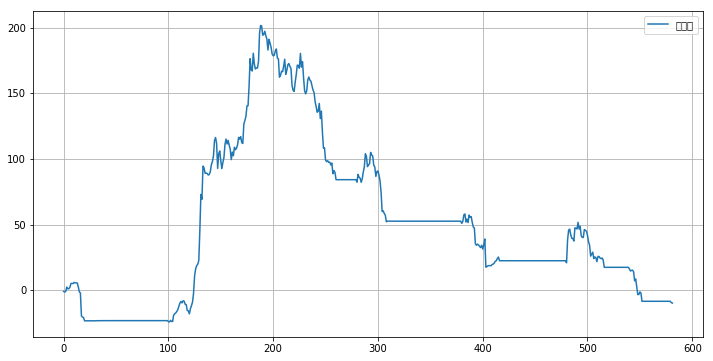

In [13]:
# 메인_처리(기준일, 공분산_산출기간, 리밸런싱_주기, 손절률, atrs1, atrs2, atrs3, atrs4, 차트출력)
메인_처리(20170701, 250, 20, 20, 2, 3, 5, 2, 1)

# 변수 최적화 시뮬레이션

In [0]:
def call_main():
    for 기간 in range(50, 501, 50):
        for 주기 in range(5, 60, 5):
            for 손절률 in range(25, 51, 5):
                for atrs1 in range(1, 11):
                    for atrs2 in range(1, 11):
                        for atrs3 in range(1, 11):
                            for atrs4 in range(1, 11):
                                메인_처리(20180101, 기간, 주기, 손절률, atrs1, atrs2, atrs3, atrs4, 0)


In [0]:
# call_main()